# Building a multi-output model with Keras

In this notebook, we will be covering some basics of what is a multi-output model in Keras and how we can take advantage of it when building our Deep Learning models. We will be using the UTK dataset, which contains pictures of people from diverse gender, races and ages.

## The dataset

The UTKFace dataset is a large dataset composed of over 20 thousand face images with their respectivce annotations of age, gender and ethnicity. The images are properly cropped into the face region, but display some variations in pose, illumination, resolution, etc.

In order to retrieve the annotations of each record, we need to parse the filenames. Each record is stored in the following format: `[age]_[gender]_[race]_[date&time].jpg`

Where:
    - age is an integer from 0 to 116
    - gender is an integer in which 0 represents male and 1 represents female
    - race is an integer from 0 to 4, denoting white, black, asian, indian and others, respectively
    - date and time, denoting when the picture was taken
    
If you want to know more about this dataset, please check their [website](http://aicip.eecs.utk.edu/wiki/UTKFace).


Let's initially create a dictionary to help us on parsing the information from the dataset, along with some other information (dataset location, training split, width and height).

In [1]:
dataset_folder_name = 'dataset/UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [2]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's also define a method to help us on extracting the data from our dataset. This function will be used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the fields (age, gender and sex) of our records.

In [3]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [4]:
df = parse_dataset(dataset_folder_name)
df.head()
print((df['race'].value_counts().values.tolist()))
print(type(df['race'].value_counts().values.tolist()))

[9639, 4295, 3786, 3305, 1564]
<class 'list'>


# Data visualization

As an important step to understand not only the distribution of our dataset, but as well the predictions generated by our model, we need to perform some data visualization process on our dataset.

Let's then define a helper function to generate pie plots based on a given Pandas series:

In [5]:
def plot_pie(pd_series, title):
    my_labels = pd_series.value_counts().index.tolist()
    my_counts = pd_series.value_counts().values.tolist()

    plt.pie(my_counts, labels=my_labels, autopct='%1.1f%%')
    plt.title(title)
    plt.axis('equal')
    plt.show()

### Race distribution

Let's start by plotting the race distribution with our predefined plot_distribution method.

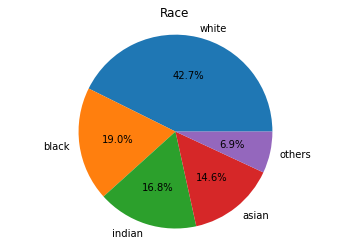

In [6]:

plot_pie(df['race'], "Race")

From a quick glance, we can see that we have almost half of the samples being from the white race, so we can expect to have a great accuracy on this given class. Other races such as black, indian and asian also show a good number of samples, probably leading us to good accuracy numbers. The race 'others' (hispanics, latinos, etc) on the other side, show a small number of samples, which may lead to a small accuracy.

### Gender distribution

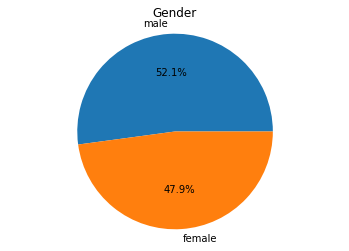

In [7]:
plot_pie(df['gender'], "Gender")

For both male and female samples, we have quite a good balanced number of records, so we should have a great accuracy for both classes when using our model.

### Age distribution

Let's also plot how our age feature is distributed over the dataset by using a simple histogram with 20 bins.

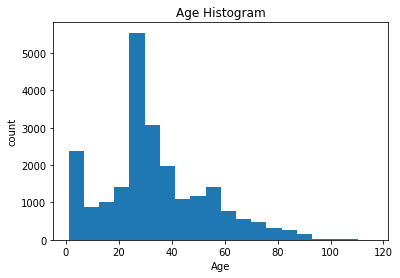

In [8]:
plt.hist(df['age'], bins=20)
plt.title("Age Histogram")
plt.xlabel("Age")
plt.ylabel("count")
plt.show()




We can also display this same plot in a pie plot. Let's group the age column into bins and then plot it with a pie chart

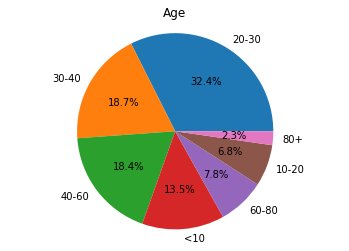

In [9]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['age'], bins, labels=names)
plot_pie(age_binned, "Age")

We can observe that our dataset is mostly composed of individuals which age varies between 20 and 30 years, followed by individuals ranging from 30-40 years and then 40-60 years old. These groups represent around 70% of our dataset, so we can believe that we are going to have a good accuracy on predicting individuals in these ranges.

We could also perform some multi-variate analysis on our dataset, but since the scope of this notebook is to demonstrate the usage of a multi-output model with Keras, we won't be covering it.

# Data preparation

In order to input our data to our Keras multi-output model, we will create a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model.

In [10]:
from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))
train_idx = train_idx[:5000]
valid_idx = valid_idx[:1000]
test_idx = test_idx[:1000]

11068
4744
6777


## Building our model

In this step, we will define our multi-output Keras model. Our model will be composed of three major branches, one for each available feature: age, gender and race. The default structure for our convolutional layers is based on a Conv2D layer with a ReLU activation, followed by a BatchNormalization layer, a MaxPooling and finally a Dropout layer. Each of these default layers is then followed by the final layer for each feature, composed by a Dense layer.

These default layers are defined on the make_default_hidden_layers method, which will be reused on building each of the branches of our model.

In [17]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras.applications import MobileNet

tf.get_logger().setLevel('INFO')
tf.debugging.set_log_device_placement(False)

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)
        print(type(x))
        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)
        print("input")
        print(inputs)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)
        print("age")
        print(age_branch)
        print(race_branch)
        print(gender_branch)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")
        #print(type(model))
        return model
    
#model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))
#print(IM_HEIGHT)
#print(IM_WIDTH)
#print(model)
#model = tf.keras.Sequential([MobileNet(input_shape=(192,192,3), include_top=False, pooling='avg',weights='imagenet'),Dense(1)])
#print(model)

input
KerasTensor(type_spec=TensorSpec(shape=(None, 198, 198, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
age
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'age_output'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='race_output/Softmax:0', description="created by layer 'race_output'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='gender_output/Sigmoid:0', description="created by layer 'gender_output'")


In [ ]:
from mobilenetv2 import MuiltiMobileModel
model = MuiltiMobileModel().build_multi_model((200,200,3))

Let's give a look into our model structure and summary, to have a better understanding of what we are building.

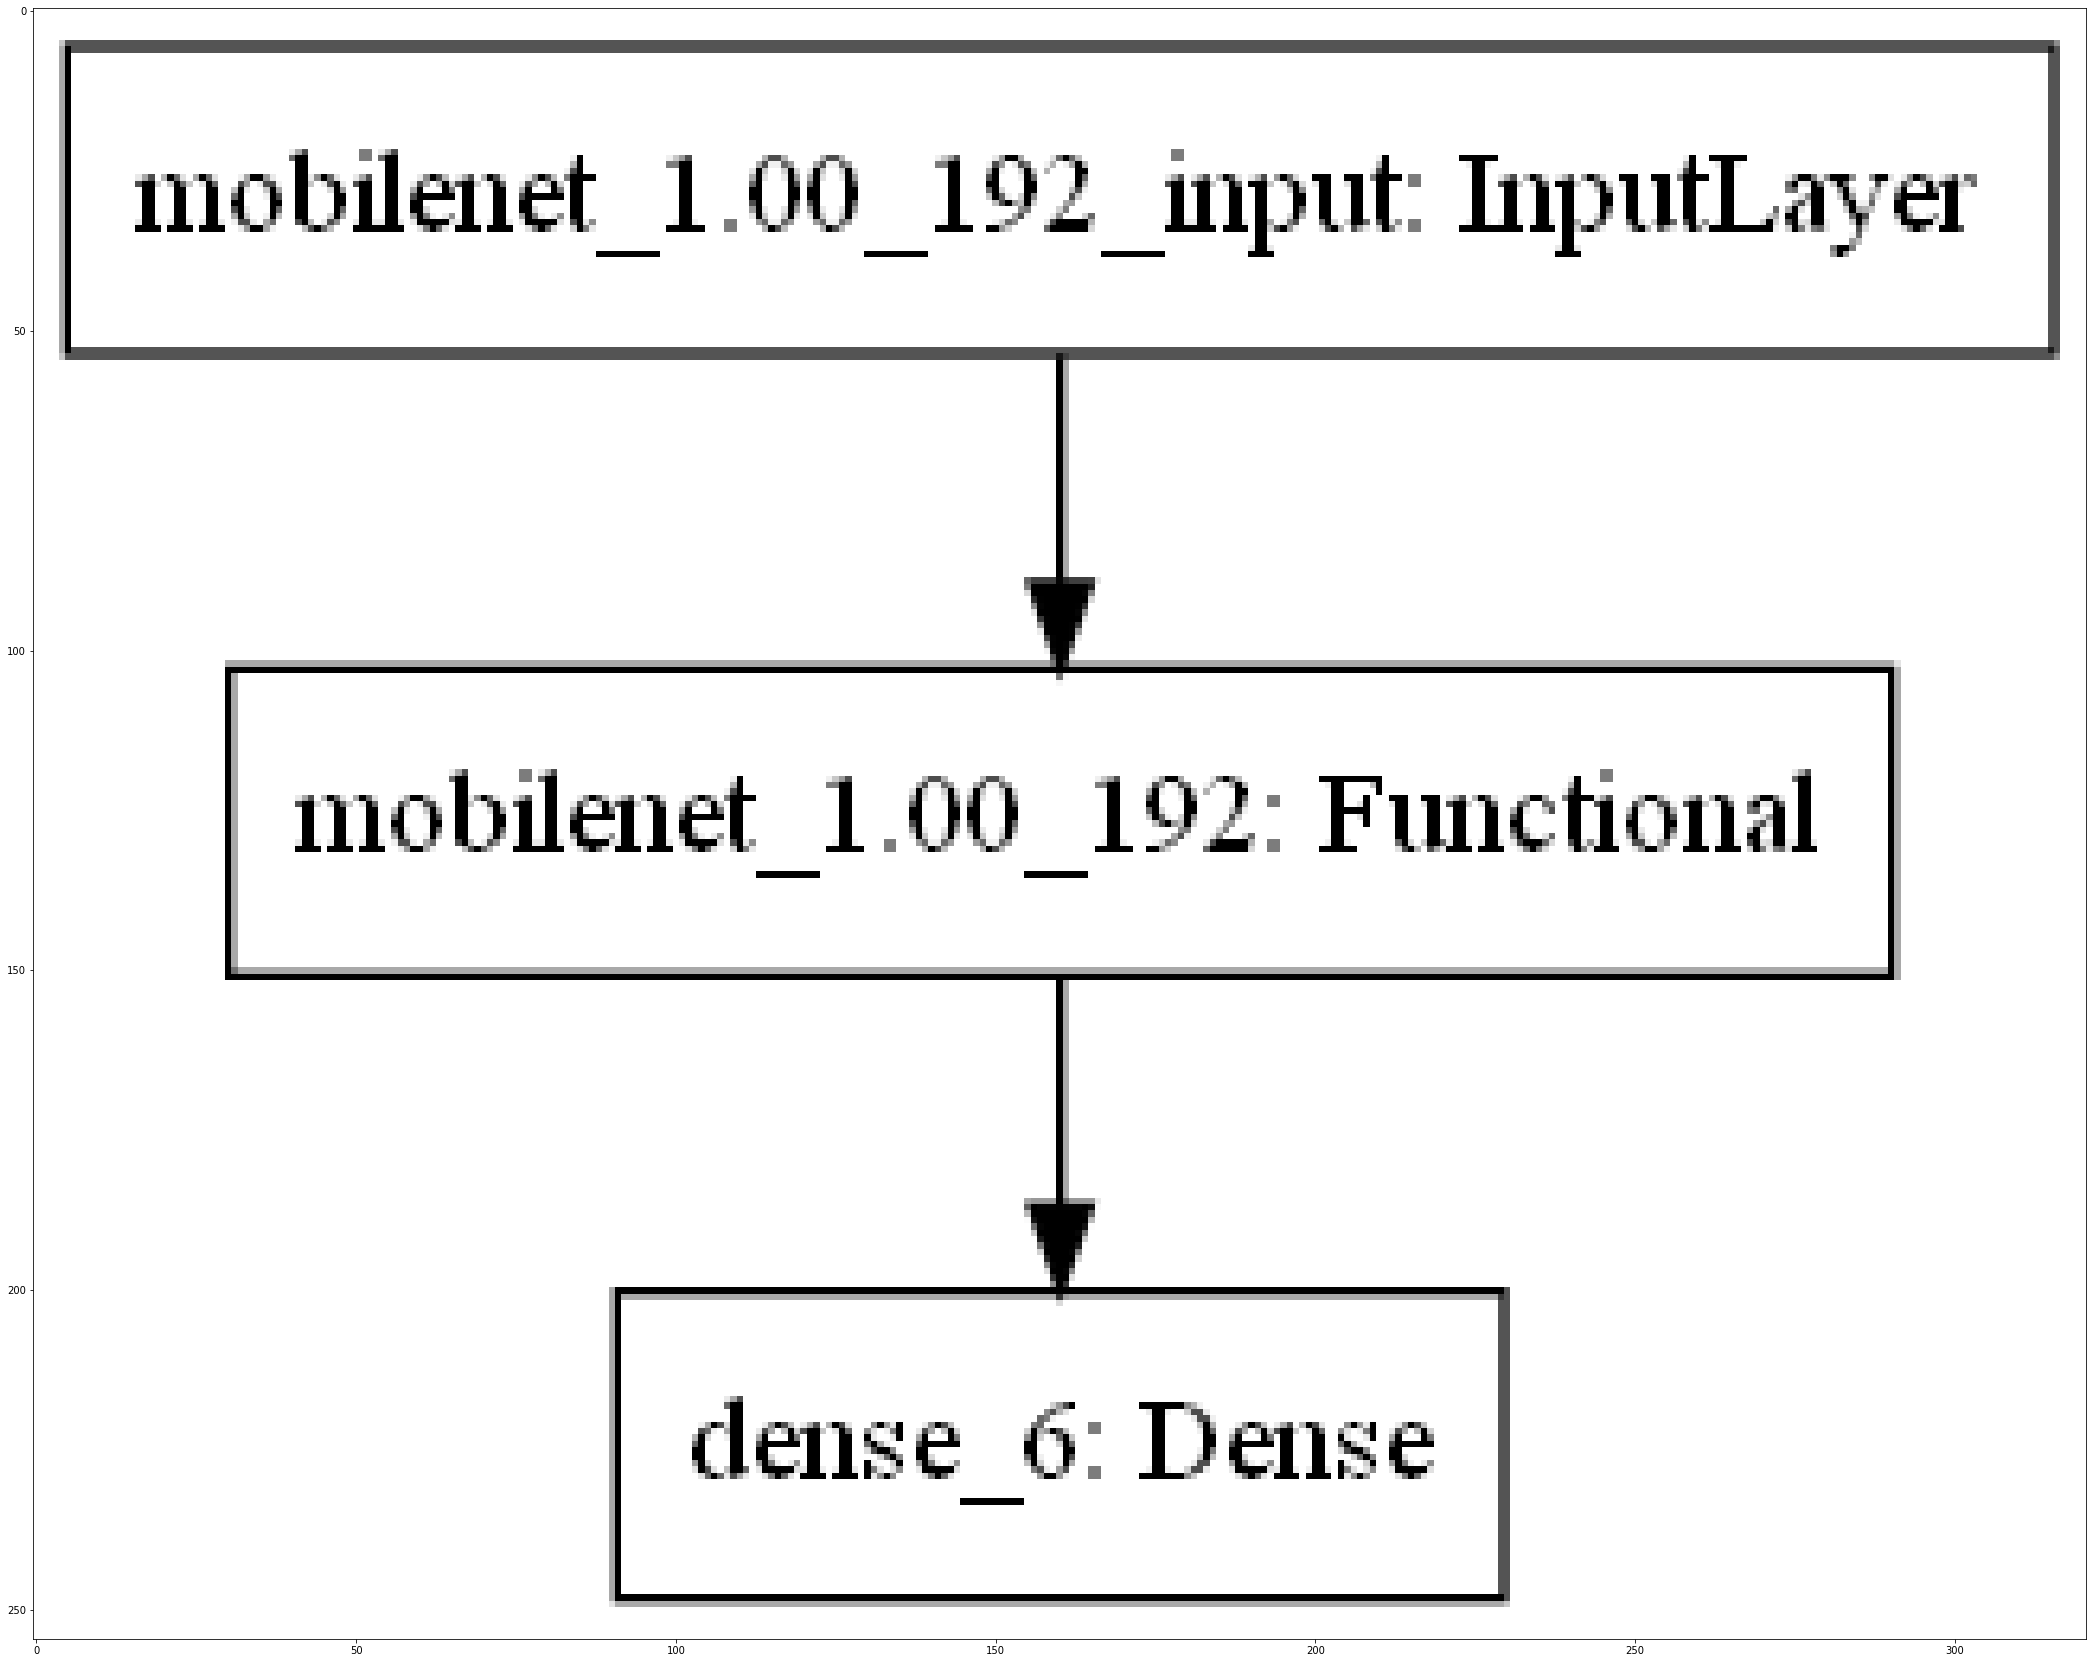

In [12]:
%matplotlib inline

from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_192 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
_________________________________________________________________


## Training our model

Now it's time to train our multi-output model, once we already have everything done. But before doing it, we need to compile our model. For this step, let's use a learning rate of 0.0004 and an Adam optimizer. We will also use custom loss weights for each feature and a custom loss function for each feature.

When building our optimizer, let's use a decay based on the learning rate divided by the number of epochs, so we will slowly be decreasing our learning rate over the epochs.

In [18]:
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 2

opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr / epochs)
print(type(opt))

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})
#model.load_weights('model_checkpoint/')

<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>


And now let's train our model with a batch size of 32 for both valid and train sets. We will be using a ModelCheckpoint callback in order to save the model on disk at the end of each epoch.

In [19]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/2
156/156 [==============================] - 72s 379ms/step - loss: 16.0997 - age_output_loss: 3.1366 - race_output_loss: 2.3147 - gender_output_loss: 0.8108 - age_output_mae: 1.4027 - race_output_accuracy: 0.3117 - gender_output_accuracy: 0.6515 - val_loss: 16.0626 - val_age_output_loss: 3.3742 - val_race_output_loss: 1.6207 - val_gender_output_loss: 1.3491 - val_age_output_mae: 1.8233 - val_race_output_accuracy: 0.4567 - val_gender_output_accuracy: 0.5232
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/2
156/156 [==============================] - 20s 126ms/step - loss: 10.6400 - age_output_loss: 2.0322 - race_output_loss: 1.6361 - gender_output_loss: 0.5690 - age_output_mae: 1.1108 - race_output_accuracy: 0.4641 - gender_output_accuracy: 0.7754 - val_loss: 29.4663 - val_age_output_loss: 6.6313 - val_race_output_loss: 1.8553 - val_gender_output_loss: 1.5814 - val_age_output_mae: 2.4109 - val_race_output_accuracy: 0.4688 - val_gender_output_accuracy: 0.5202

In [22]:
model.save('models')

PermissionDeniedError: Failed to create a directory: /; Permission denied [Op:MergeV2Checkpoints]

In [ ]:
model = keras.model.load_model('models')

In [ ]:
#Let's plot our losses and accuracy curves for each feature:

### Race accuracy

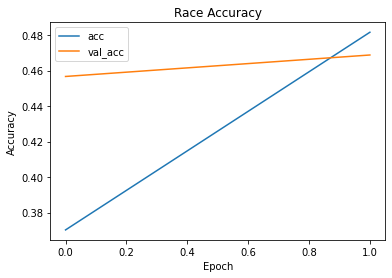

In [20]:
plt.plot(history.history["race_output_accuracy"], label = "acc")
plt.plot(history.history["val_race_output_accuracy"], label = "val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Race Accuracy")
plt.legend()
plt.show()


### Gender accuracy

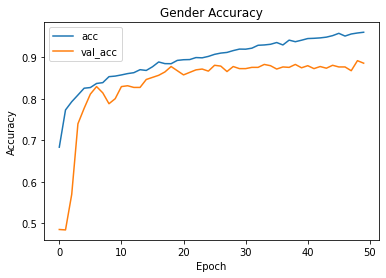

In [47]:
plt.plot(history.history["gender_output_accuracy"], label = "acc")
plt.plot(history.history["val_gender_output_accuracy"], label = "val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Gender Accuracy")
plt.legend()
plt.show()

### Age Mean Absolute Error

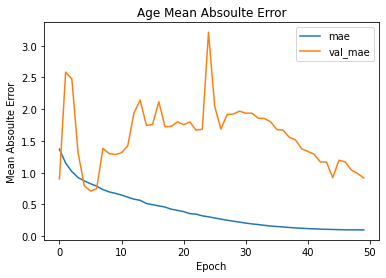

In [48]:
plt.plot(history.history["age_output_mae"], label = "mae")
plt.plot(history.history["val_age_output_mae"], label = "val_mae")
plt.xlabel("Epoch")
plt.ylabel("Mean Absoulte Error")
plt.title("Age Mean Absoulte Error")
plt.legend()
plt.show()

### Overall loss

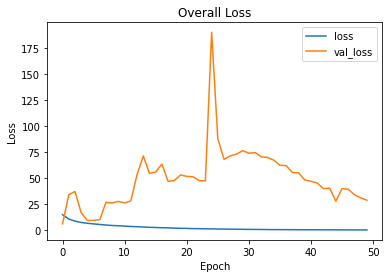

In [49]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Overall Loss")
plt.legend()
plt.show()

## Evaluating our model on the test set

In order to assess how our model performs on the test set, let's use our UTK data generator class, but this time using the test indexes. We will then call the predict_generator method from our trained model, which will output our the predictions for the test set.

In [7]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

NameError: name 'data_generator' is not defined

Let's iterate one time over all our test samples, in order to have their labels into a single list. We will also extract the arg max of each record, in order to retrieve the top predictions and ground truths.

In [68]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

And finally, let's print the classification reports for each feature on the test set.

In [52]:
from sklearn.metrics import classification_report

cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.71      0.89      0.79       394
       black       0.83      0.76      0.79       174
       asian       0.66      0.73      0.69       119
      indian       0.75      0.52      0.61       147
      others       0.25      0.05      0.08        62

    accuracy                           0.72       896
   macro avg       0.64      0.59      0.59       896
weighted avg       0.70      0.72      0.70       896



From the report above, we can see that our model is really good at predicting asian and black individuals, with a precision of 0.86, followed by white people with 0.80 and indian with 0.74. The race 'others' shows a precision of only 0.38, but we need to take into consideration that this group is composed of different races and ethnicities along with a small number of samples, when compared to the other groups. The weighted accuracy for this classification task is 78%, showing that our classifier was able to properly learn patterns to distinguish different types of races.

In [53]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.91      0.87      0.89       473
      female       0.86      0.90      0.88       423

    accuracy                           0.89       896
   macro avg       0.89      0.89      0.89       896
weighted avg       0.89      0.89      0.89       896



In [54]:
from sklearn.metrics import r2_score

print('R2 score for age: ', r2_score(age_true, age_pred))

R2 score for age:  -268.3551891470952


### Example of predictions

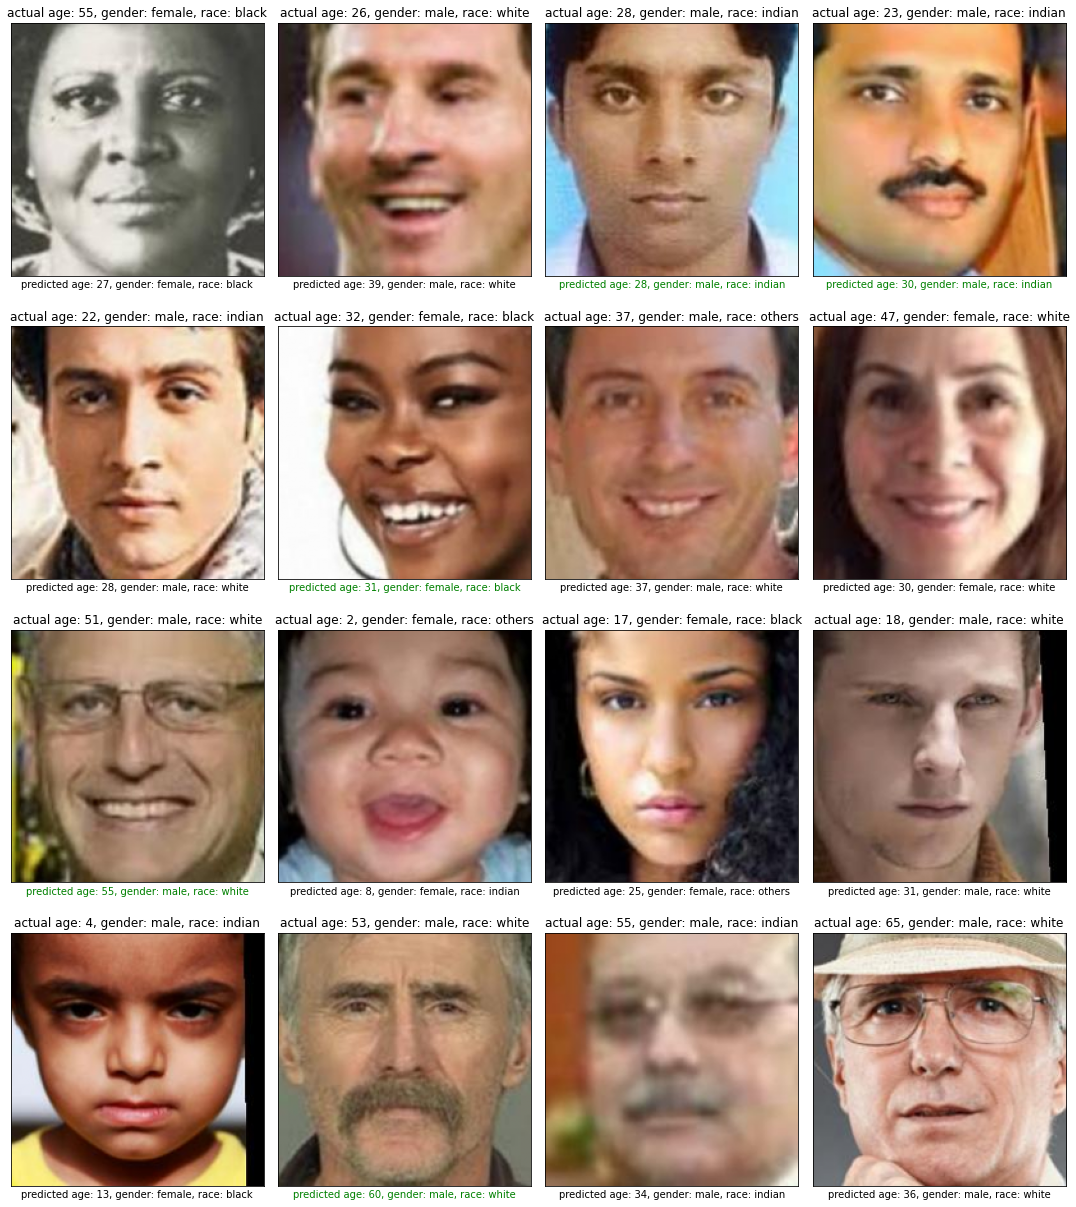

In [55]:
import math
n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    
    cur_age_pred = age_pred[img_idx]
    cur_age_true = age_true[img_idx]
    
    cur_gender_pred = gender_pred[img_idx]
    cur_gender_true = gender_true[img_idx]
    
    cur_race_pred = race_pred[img_idx]
    cur_race_true = race_true[img_idx]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('predicted age: {}, gender: {}, race: {}'.format(int(age_pred[img_idx]),
                            dataset_dict['gender_id'][gender_pred[img_idx]],
                               dataset_dict['race_id'][race_pred[img_idx]]))
    
    ax.set_title('actual age: {}, gender: {}, race: {}'.format(int(age_true[img_idx]),
                            dataset_dict['gender_id'][gender_true[img_idx]],
                               dataset_dict['race_id'][race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('preds.png')

# References

UTK Face Dataset: http://aicip.eecs.utk.edu/wiki/UTKFace

Keras Multi-output documentation: https://keras.io/getting-started/functional-api-guide/

SanjayaSubedi post on multi-output model: https://sanjayasubedi.com.np/deeplearning/multioutput-keras/

PyImageSearch post on FashionNet: https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

Plotly: https://plot.ly/

In [43]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)


# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Num GPUs Available:  1
2.4.1
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
